In [136]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import time
import zipfile
import os
from torch.utils.data import DataLoader, Dataset

In [137]:
#pre-processing
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(root='./face',transform=transform)

In [138]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=2),
     transforms.RandomRotation(10, expand=False),
     transforms.ColorJitter(brightness=(0.3, 2.5)),
     transforms.ColorJitter(contrast=(0.3, 2.5)),
     transforms.RandomAffine(10),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset=torchvision.datasets.ImageFolder(root='./face/train',transform=transform_train)
testset=torchvision.datasets.ImageFolder(root='./face/test',transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [139]:
classes = trainset.classes

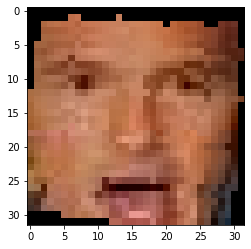

N e i l _ P a t r i c k _ H a r r i s


In [140]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images[0]))
# 정답(label) 출력
print(' '.join('%4s' % classes[labels[0]]))

In [141]:
AlexNet_model = torch.load('model.pt')

In [142]:
AlexNet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(3

In [143]:
#Remove Conv5
AlexNet_model.features = nn.Sequential(
    AlexNet_model.features[0],AlexNet_model.features[1],AlexNet_model.features[2],
    AlexNet_model.features[3],AlexNet_model.features[4],AlexNet_model.features[5],
    AlexNet_model.features[6],AlexNet_model.features[7],AlexNet_model.features[8],
    AlexNet_model.features[9],AlexNet_model.features[10],AlexNet_model.features[11],AlexNet_model.features[12],
    AlexNet_model.features[13],AlexNet_model.features[17]
)

In [144]:
#Remove FC1,FC2
AlexNet_model.classifier = nn.Sequential(AlexNet_model.classifier[0],AlexNet_model.classifier[6])

#Updating the last classifier that is the output layer of the network. Make sure to have 100 output nodes if we are going to get 10 class labels through our model.
AlexNet_model.classifier[1] = nn.Linear(18816,100)

In [145]:
AlexNet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2

In [146]:
#Instantiating CUDA device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Weight initializing
#AlexNet_model.apply(weight_init)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cuda:1


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2

In [147]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

In [148]:
# LR setting for transfer learning

optimizer = optim.Adam([
                {'params': AlexNet_model.features[0].parameters(), 'lr': 0},      #conv1 -freeze
                {'params': AlexNet_model.features[4].parameters(), 'lr': 0.0001}, #conv2 -finetune
                {'params': AlexNet_model.features[8].parameters(), 'lr': 0.00025}, #conv3 -finetune
                {'params': AlexNet_model.features[11].parameters(), 'lr': 0.0005}, #conv 4 -retrain
                {'params': AlexNet_model.classifier[1].parameters(), 'lr': 0.0005}  #output -retrain
], lr=0.0005, weight_decay=0.0001)

#Xavier init
init.xavier_normal_(AlexNet_model.classifier[1].weight.data)
init.xavier_normal_(AlexNet_model.features[11].weight.data)

tensor([[[[-1.3302e-02, -3.9797e-03, -2.2649e-02],
          [-5.5894e-04,  8.6894e-03,  6.7488e-03],
          [ 7.7010e-03, -2.9781e-02,  3.7352e-02]],

         [[ 2.7930e-02, -1.8334e-02, -7.0552e-03],
          [ 3.0655e-02,  1.1154e-02,  5.1735e-03],
          [-2.7179e-03,  2.9056e-03,  3.8166e-03]],

         [[ 5.4330e-04, -1.0214e-02,  2.4140e-02],
          [-2.9478e-03,  4.0599e-02,  1.8061e-03],
          [-7.2722e-03, -2.2102e-04,  2.1179e-02]],

         ...,

         [[ 2.7252e-02, -1.2425e-02, -2.0199e-02],
          [-2.5655e-02, -3.0722e-02, -3.3055e-03],
          [ 2.1495e-02,  3.6331e-03,  1.7423e-02]],

         [[-2.0632e-02, -2.4632e-02, -1.1287e-02],
          [-2.0533e-02, -2.2209e-03, -2.4653e-02],
          [-1.4398e-02, -1.8428e-04, -2.0571e-03]],

         [[-6.8481e-03, -3.7260e-02,  1.0656e-02],
          [-2.0327e-02, -2.7070e-02,  6.5601e-03],
          [ 1.6672e-02,  1.0072e-02,  5.2891e-03]]],


        [[[ 1.1851e-02,  3.5339e-02,  5.7633e-04],
  

In [149]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
#optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.0005, momentum=0.9)
#optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr = 0.0005, weight_decay=0.0001)
start = time.time()


for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 8 == 0:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 8))
            running_loss = 0.0
         
    #Testing Accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(testloader,0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = AlexNet_model(images)
            loss = criterion(outputs, labels)
            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()
            # print statistics
            running_loss += loss.item()

    test_loss = running_loss/i
    test_acc = 100 * correct_test / total_test
                    
                    
    #Training Accuracy
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        running_loss=0.0
        for j,data in enumerate(trainloader,0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = AlexNet_model(images)
            loss = criterion(outputs, labels)
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            running_loss += loss.item()
            
    train_loss = running_loss /j
    train_acc = 100 * correct_train / total_train
    
    if abs(train_acc-test_acc)<=10:
        print("epoch:%d train_acc:%0.2f test_acc:%0.2f" % (epoch+1,train_acc, test_acc))
        print("epoch:%d train_loss:%0.2f test_loss:%0.2f" % (epoch+1,train_loss, test_loss))
    else:
        print("Overfitting!", train_acc, test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print("time: {}".format(time.time()-start))
print('Finished Training of AlexNet')

[1,     8] loss: 5.209
[1,    16] loss: 4.833
epoch:1 train_acc:3.90 test_acc:4.40
epoch:1 train_loss:4.90 test_loss:4.90
time: 6.42399001121521
[2,     8] loss: 4.463
[2,    16] loss: 4.290
epoch:2 train_acc:10.40 test_acc:9.90
epoch:2 train_loss:4.33 test_loss:4.27
time: 12.806955099105835
[3,     8] loss: 3.989
[3,    16] loss: 3.812
epoch:3 train_acc:18.35 test_acc:16.10
epoch:3 train_loss:3.83 test_loss:3.89
time: 19.18428659439087
[4,     8] loss: 3.555
[4,    16] loss: 3.345
epoch:4 train_acc:26.25 test_acc:21.50
epoch:4 train_loss:3.40 test_loss:3.62
time: 25.572815656661987
[5,     8] loss: 3.147
[5,    16] loss: 3.087
epoch:5 train_acc:34.60 test_acc:26.00
epoch:5 train_loss:2.98 test_loss:3.32
time: 31.95601487159729
[6,     8] loss: 2.759
[6,    16] loss: 2.678
epoch:6 train_acc:40.85 test_acc:31.70
epoch:6 train_loss:2.60 test_loss:3.04
time: 38.33068132400513
[7,     8] loss: 2.501
[7,    16] loss: 2.496
Overfitting! 46.25 32.7
time: 44.701992988586426
[8,     8] loss: 2.

[83,    16] loss: 0.153
Overfitting! 96.9 61.1
time: 528.8745265007019
[84,     8] loss: 0.166
[84,    16] loss: 0.158
Overfitting! 97.6 63.6
time: 535.2475080490112
[85,     8] loss: 0.138
[85,    16] loss: 0.152
Overfitting! 96.8 62.0
time: 541.6306941509247
[86,     8] loss: 0.136
[86,    16] loss: 0.140
Overfitting! 97.6 65.4
time: 548.0077471733093
[87,     8] loss: 0.110
[87,    16] loss: 0.157
Overfitting! 96.7 63.9
time: 554.3874490261078
[88,     8] loss: 0.112
[88,    16] loss: 0.125
Overfitting! 97.0 65.0
time: 560.7532370090485
[89,     8] loss: 0.119
[89,    16] loss: 0.114
Overfitting! 97.25 62.6
time: 567.1224863529205
[90,     8] loss: 0.124
[90,    16] loss: 0.156
Overfitting! 96.95 64.4
time: 573.4870505332947
[91,     8] loss: 0.130
[91,    16] loss: 0.125
Overfitting! 97.1 60.4
time: 579.8603813648224
[92,     8] loss: 0.135
[92,    16] loss: 0.109
Overfitting! 96.05 62.1
time: 586.2339551448822
[93,     8] loss: 0.140
[93,    16] loss: 0.131
Overfitting! 97.25 63.3

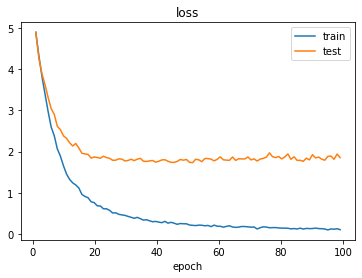

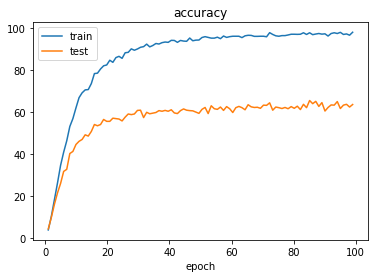

Train accuracy:  97.85
Test accuracy:  63.5


In [150]:
# plotting test/train loss
xrange = np.linspace(1,100,100,endpoint=False)
plt.title('loss')
plt.plot(xrange,train_losses), plt.plot(xrange,test_losses)
plt.legend(['train', 'test'])
plt.xlabel("epoch")
plt.show()

# plotting test/train accuracy
plt.title('accuracy')
plt.plot(xrange,train_accs), plt.plot(xrange,test_accs)
plt.legend(['train', 'test'])
plt.xlabel("epoch")
plt.show()
print("Train accuracy: ", train_accs[-1])
print("Test accuracy: ",test_accs[-1])